# codetest4_seedtag

- Author: mmaguero
- Date: 2020-12-12

In [ ]:
!pip install pandas sklearn click nltk XGBoost joblib spacy

In [ ]:
import nltk
nltk.download('stopwords')

In [ ]:
!python -m spacy download en_core_web_md

## Load dataset

In [1]:
from sklearn.model_selection import train_test_split
from preprocessing import load_data

In [2]:
mydf = load_data(path="dataset", extension="",output="data/corpus.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3859 entries, 0 to 3858
Data columns (total 3 columns):
id          3859 non-null object
category    3859 non-null object
text        3859 non-null object
dtypes: object(3)
memory usage: 90.6+ KB


Es más conveniente tenerlos así: id, categoría, texto. Viene bien para cualquier análisis que se quiera hacer y para la pipeline de entrenamiento.

In [3]:
# check files
! ls dataset/*/* | wc -l

3859


El número de files coinicide con el número de rows (text non null) en el frame

In [4]:
# see some samples
mydf.sample(10)

,id,category,text
55,178962,intelligence,"b""n article <mwalker-160493090617@mwalker.npd...."
1951,102701,politics,"b""ticle-I.D.: alleg.1993Apr6.210157.2758\n\nIn..."
2710,54608,weapons,"b""n <C5sv4r.HFA@news.cso.uiuc.edu> irvine@uxh...."
1451,60253,exploration,b'ticle-I.D.: topaz.STEINLY.93Apr6170313\n\nIn...
2247,104342,politics,"b'n article 120399@netnews.upenn.edu, sepinwal..."
1673,104689,politics,"b' had heard the rumors about LA, Cin, Hou, an..."
3267,38376,headhunters,b'\nComputer Graphics Resource Listing : WEEKL...
3456,53135,logistics,b'n article <1qi156INNf9n@senator-bedfellow.MI...
2284,54537,weapons,"b"" predict that the outcome of the study of wh..."
3345,38651,headhunters,b're there any TIFF to anything programs out t...


In [5]:
# simple lang identification: its have "the": https://en.wikipedia.org/wiki/The (most common word)
mydf["the"] = mydf.text.apply(lambda a: 1 if "the" in str(a).split() else 0)
sum(mydf["the"])

3571

In [6]:
mydf[mydf.the==0]["text"].sample(10)

703     b'n article <C5r66A.6rB@srgenprp.sr.hp.com> al...
3059    b'C51Eyz.4Ix@optimla.aimla.com> <1993Apr6.1445...
2985    b'oes anyone have a radon transform in C that ...
865     b'ccording to a LoJack representative I saw re...
2989    b'e have been using Iterated Systems compressi...
2667    b"n article <1qrn3aINN4rq@clem.handheld.com> j...
553     b"ou can be sure they wouldn't do it if it was...
1148    b" C-3's bird may be flaking out and expecting...
2087    b"ello All,\n\nI'd like to learn how to keep s...
1766    b"ticle-I.D.: agate.1ps77v$5dr\n\n\n\t     MLB...
Name: text, dtype: object

...es un dataset en English

## Preprocessing

- For train and test:
    - remove null texts
    - spit data in 80/10/10 train/test/eval
- For train and test: 
    - clean text:
    - Experimento 1
        - lowercase
        - remove "\n"
    - Experimento 2 (add)
        - clean: ignore_url=True, content_words=True, lemma=True, that is, URL out, only content words with lemma
- Inference:
    - the (best model) last experiment setup

## Train

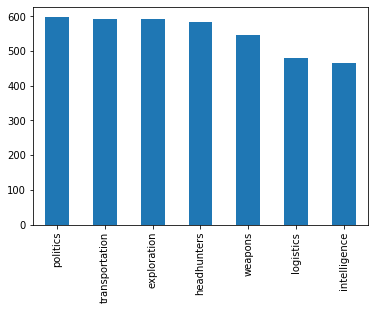

In [7]:
mydf['category'].value_counts().plot(kind='bar')

Parecen clases balanceadas, excepto logistics o intelligence

Entrenamos 6 modelos bien conocidos para clasificación (también para textos):
- MNB, Multinomial Naive Bayes, probabilista simple y muy usado porque produce resultados tan buenos como otros modelos mas sofisticados
- LogReg, Regresión Logística, multifuncional, así como MNB, simple :)! una red neuronal miniatura?
- RFC, Random Forests, un ensemble de árboles! 
- SVC, Linear Support Vector Machine, busca la distancia en el hiperplano para clasificar y suele ser muy estable.
- XGBoost, un ensemble y suelen funcionar bien con variables catégoricas y pocas clases. 
- KNN, K-Vecinos cercanos, cuando llega un nuevo texto, se toma su vector de características y se extraen los k textos más cercanos de nuestra base de datos. Después, se etiqueta el nuevo texto conforme a las categorías de sus vecinos. Idealmente, todos sus vecinos tendrán los mismas. Ya veremos...

Todos los modelos, primero pasan por una pipeline, además del preprocesado:
- CountVectorizer, una bolsa de palabras con sus frecuencias
- Tf-idfVectorizer, transform, para responder a: how relevant a word is to a document in a collection of documents?

### Experimento 1

_Pipeline_:

`pipeline[name] = Pipeline([
                ('vect', CountVectorizer(stop_words=stop_words,preprocessor=clean_text)),
                ('tfidf', TfidfVectorizer()),
                ('clf', model),
            ], verbose=1)`
            
_Models params_:

`models = {"MNB": MultinomialNB(fit_prior=True, class_prior=None),
          "SVC":LinearSVC(),
          "LogReg":LogisticRegression(solver='sag',n_jobs=-1),
          "XGB":XGBClassifier(n_jobs=-1,eval_metric='merror'),
          "RFC":RandomForestClassifier(n_jobs=-1),
          "KNN":KNeighborsClassifier(n_neighbors=10,n_jobs=-1)} # slow, use 10 neighbors`

In [11]:
!python3 train.py "dataset"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3859 entries, 0 to 3858
Data columns (total 3 columns):
id          3859 non-null object
category    3859 non-null object
text        3859 non-null object
dtypes: object(3)
memory usage: 90.6+ KB
... Processing
Init train MNB
[Pipeline] .............. (step 1 of 3) Processing vect, total=  58.8s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   1.5s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.0s
End train MNB
Save/load model category_MNB
accuracy_test:   0.837
accuracy_eval:   0.836
classification report:
TEST
                 precision    recall  f1-score   support

   exploration       0.94      0.84      0.89        56
   headhunters       0.65      0.98      0.78        51
  intelligence       0.95      0.43      0.59        42
     logistics       0.96      0.88      0.91        49
      politics       0.74      0.96      0.84        57
transportation       0.89      0.87      0.88        68


[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   1.5s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   1.2s
End train RFC
Save/load model category_RFC
accuracy_test:   0.722
accuracy_eval:   0.693
classification report:
TEST
                 precision    recall  f1-score   support

   exploration       0.91      0.70      0.79        56
   headhunters       0.42      0.92      0.58        51
  intelligence       0.78      0.43      0.55        42
     logistics       0.88      0.76      0.81        49
      politics       0.82      0.93      0.87        57
transportation       0.84      0.72      0.78        68
       weapons       0.82      0.55      0.66        58

      accuracy                           0.72       381
     macro avg       0.78      0.71      0.72       381
  weighted avg       0.79      0.72      0.73       381

EVAL
                 precision    recall  f1-score   support

   exploration       0.81      0.68      0.74        73
  

Con **Linear SVC**, llegamos a **93%** de accuracy en test (0.934) [en eval, 0.89, lo que nos da un mean de 0.912], o acierto 1 a 1, true_predict=true_label, siendo la categoría mejor clasificada *exploration* y la peor, *intelligence*, esto según su F1-score, que es una métrica de la media armónica calculada a partir de precision (¿Qué proporción de identificaciones positivas fue realmente correcta?) y recall (¿Qué proporción de positivos reales se identificó correctamente?). Esto último, se repite para todos los demás clasificadores, excepto para KNN (peor: *headhunters* y el segundo peor: *intelligence*).

Podemos explorar mientras la categoría, intelligence:

In [58]:
pd.set_option('display.max_colwidth', -1)

In [94]:
mydf[mydf.category=='intelligence']['text'].sample(1)

345    b'n <C50sJG.3Eu@voder.nsc.com> matt@galaxy.nsc.com (Matt Freivald x8043) writes:\n\n>In article 164633 in talk.politics.misc, bob1@cos.com (Bob Blackshaw) writes:\n\n>>>>And Ms. Regard, please don\'t give us the trite "you can\'t legislate \n>>>>morality" nonsense again: there is little else that is legislated, \n>>>>including the moral concept of "rights".\n\n>>Really? Pure Socialism had this belief, and fell flat on its ass by\n>>attempting to follow such reasoning. Suppose you pass a law that\n>>states that I must love my neighbour, regardless of race, religion,\n>>etc. How exactly do you plan to enforce such a law? Better yet, how\n>>do you plan to measure compliance? And even if you overcome those\n>>two obstacles, how will you ever know if I have become *more moral*\n>>or not?\n\n>You either missed the point or are being somewhat disingenuous;  I have\n>never heard anyone suggest that you can legislate what people think.\n>Laws are based on either expediency (i.e. traffic 

In [93]:
mydf[mydf.category=='exploration']['text'].sample(1)

1292    b'ticle-I.D.: news.C51rzx.AC3\n\nnsmca@aurora.alaska.edu writes:\n\n[Excellent discussion of DC-X landing techniques by Henry deleted]\n\n>Since the DC-X is to take off horizontal, why not land that way??\n\nThe DC-X will not take of horizontally.  It takes of vertically. \n\n>Why do the Martian Landing thing.. \n\nFor several reasons.  Vertical landings don\'t require miles of runway and limit\nnoise pollution.  They don\'t require wheels or wings.  Just turn on the engines\nand touch down.  Of course, as Henry pointed out, vetical landings aren\'t quite\nthat simple.\n\n>Or am I missing something.. Don\'t know to\n>much about DC-X and such.. (overly obvious?).\n\nWell, to be blunt, yes.  But at least you\'re learning.\n\n>Why not just fall to earth like the russian crafts?? Parachute in then...\n\nThe Soyuz vehicles use parachutes for the descent and then fire small rockets\njust before they hit the ground.  Parachutes are, however, not especially\npractical if you want to re

Comparando con exploration, parecen ser textos más largos de media, comprobemos...

In [81]:
mydf['text_length'] = mydf.text.apply(lambda a: len(a))
mydf['text_token_count'] = mydf.text.apply(lambda a: len(a.split()))

In [102]:
mydf[mydf.category=='intelligence']['text_length'].mean(),mydf[mydf.category=='intelligence']['text_token_count'].mean()

(2646.2903225806454, 422.73333333333335)

In [104]:
mydf[mydf.category=='exploration']['text_length'].mean(),mydf[mydf.category=='exploration']['text_token_count'].mean()

(1789.3490725126476, 273.5615514333895)

Vemos que si... a lo mejor con rich text mining el texto...mejora

### Experimento 2

_Pipeline_:

`pipeline[name] = Pipeline([
                ('vect', CountVectorizer(stop_words=stop_words,preprocessor=clean_text)), # clean_text extended: only words, lemma, content words
                ('tfidf', TfidfVectorizer()),
                ('clf', model),
            ], verbose=1)`
            
_Models params_:

`models = {"MNB": MultinomialNB(fit_prior=True, class_prior=None),
          "SVC":LinearSVC(),
          "LogReg":LogisticRegression(solver='sag',n_jobs=-1),
          "XGB":XGBClassifier(n_jobs=-1,eval_metric='merror'),
          "RFC":RandomForestClassifier(n_jobs=-1),
          "KNN":KNeighborsClassifier(n_neighbors=10,n_jobs=-1)} # slow, use 10 neighbors`

In [12]:
!python3 train.py "dataset"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3859 entries, 0 to 3858
Data columns (total 3 columns):
id          3859 non-null object
category    3859 non-null object
text        3859 non-null object
dtypes: object(3)
memory usage: 90.6+ KB
... Processing
Init train MNB
[Pipeline] .............. (step 1 of 3) Processing vect, total=  28.3s
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   1.3s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.0s
End train MNB
Save/load model category_MNB
accuracy_test:   0.893
accuracy_eval:   0.887
classification report:
TEST
                 precision    recall  f1-score   support

   exploration       0.98      0.92      0.95        64
   headhunters       0.79      0.98      0.88        51
  intelligence       1.00      0.50      0.67        44
     logistics       0.94      0.88      0.91        51
      politics       0.91      0.96      0.94        54
transportation       0.88      0.95      0.91        62


[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   1.3s
[Pipeline] ............... (step 3 of 3) Processing clf, total=   0.9s
End train RFC
Save/load model category_RFC
accuracy_test:   0.804
accuracy_eval:   0.826
classification report:
TEST
                 precision    recall  f1-score   support

   exploration       0.90      0.70      0.79        64
   headhunters       0.58      0.92      0.71        51
  intelligence       0.86      0.57      0.68        44
     logistics       0.91      0.82      0.87        51
      politics       0.71      0.96      0.82        54
transportation       0.89      0.89      0.89        62
       weapons       0.96      0.74      0.84        66

      accuracy                           0.80       392
     macro avg       0.83      0.80      0.80       392
  weighted avg       0.84      0.80      0.81       392

EVAL
                 precision    recall  f1-score   support

   exploration       0.88      0.80      0.84        65
  

Bien, con rich text mining, conseguimos subir las metrics, pero no subir la de la categoría *intelligence* (F1-Score) en el mejor modelo **Linear SVC**, pero en las demás, si. Lo que prueba un poco la teoría. Conseguimos un accuracy en test y eval del **0.9265** para el mejor modelo, con metrics bastante equilibradas en su avg.

Un párrafo aparte, necesita el KNN, se ve que el rich text mining lo tiró al piso, cuando presentaba el modelo hablaba de los vecinos, pero al hacer un clean text casi extremo, quedaron muy singulares (sin vecinos?).

Como baseline, está muy bien, quizá con estos modelos se podrían probar más cosas: trabajando abreviaturas? o ir jugando con las combinaciones del clean_text function, haciendo cutt-off del vectorizer...haciendo gridsearch para encontrar el mejor modelo...también probar k-fold... incluso SMOTE para esas clases, con pocas muestras (e.g., *intelligence*)

Lo siguiente sería escalar a Deep Learning: CNN, LSTM...o sus combinaciones...o bien, transformers, BERT por ejemplo, incluso haciendo fine-tuning (aunque ya se necesita otra capacidad de cómputo)

## Classify

In [13]:
# read files
import glob
import random
#
files = glob.glob("{}/*/*{}".format("dataset",""))
sample = random.sample(files, 3)
sample

['dataset/logistics/51131',
 'dataset/weapons/54387',
 'dataset/intelligence/178521']

In [17]:
!python3 classify.py "models/category_SVC.joblib" 'dataset/logistics/51131' 'dataset/weapons/54387' 'dataset/intelligence/178521'

dataset/logistics/51131 logistics 
dataset/weapons/54387 weapons 
dataset/intelligence/178521 intelligence 


Utilizamos el mejor modelo, del experimento 2. Sus metrics son:

_test_

`(metric, precision, recall, f1-score, support)
accuracy                            0.93       392
macro avg       0.93      0.93      0.93       392
weighted avg    0.93      0.93      0.93       392`

_eval_

`(metric, precision, recall, f1-score, support)
accuracy                            0.92       380
macro avg       0.92      0.92      0.92       380
weighted avg    0.92      0.92      0.92       380`

*La misión es conseguir que el sistema de clasificación sea capaz de clasificar una
nueva transmisión de manera automática para que el departamento de operaciones pueda evaluar
las amenazas más rápido.* Misión cumplida, pero...

entonces a lo mejor al departamento de operaciones le interese evaluar las amenazas en pares de categorías, esto es, sugiriendo, además de la categoría predicha por nuestro clasificador, la segunda con más confidence. Así leyendo rápidamente en una pantalla o panel el mensaje [acá puede haber una tercera misión de text-summarization? ;)], ofreciendo dos posibles códigos, les ayude a decidir dónde se categoriza cada amenaza :)

**Try it...**

In [16]:
!python3 classify.py --pair_code "models/category_SVC.joblib" 'dataset/logistics/51131' 'dataset/weapons/54387' 'dataset/intelligence/178521'

dataset/logistics/51131 logistics 2nd option: transportation
dataset/weapons/54387 weapons 2nd option: exploration
dataset/intelligence/178521 intelligence 2nd option: transportation


-Fin de la transmisión-

In [21]:
!python3 train.py "dataset"